# Import

In [1]:
import pandas as pd
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn import preprocessing

#from google.colab import drive

#drive.mount("/content/gdrive")#, force_remount=True)

#da se prikazu svi stupci

pd.set_option('display.max_columns', None)

pd.set_option('mode.chained_assignment', None)

#za velicinu slika
sns.set(rc={'figure.figsize':(20,10)})

#import warnings
#warnings.filterwarnings('ignore')

#path=r"C:\Users\Ivan Emanuel Pavlov\OneDrive - Prirodoslovno-matematički fakultet\Github\LUMEN2021"

#cd "C:\Users\Ivan Emanuel Pavlov\OneDrive - Prirodoslovno-matematički fakultet\Github\LUMEN2021"





#dolje se premještamo u direktorij u kojemu se nalazi notebook i dataset (druga osoba koja vrti kod mora postaviti svoj path naravno)

In [2]:
cd "C:\Users\Ivan Emanuel Pavlov\OneDrive - Prirodoslovno-matematički fakultet\Github\LUMEN2021"

C:\Users\Ivan Emanuel Pavlov\OneDrive - Prirodoslovno-matematički fakultet\Github\LUMEN2021


In [32]:
# we are importing dataframes

df2=pd.read_csv(r"LUMEN_DS.csv",sep="|",encoding="utf-16")

df_model=pd.read_csv(r"data_za_model.csv",sep=",")



C:\Users\Ivan Emanuel Pavlov\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (16,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Feature engineering

In [33]:
df2=df2.drop("Sales Channel - Grouping",axis=1)
df2=df2.dropna(how="any")


#we are creating a new timelike variables ( the refererence point is 2018-01-01)

def months(x):
    return np.round(x.days/30)

date_names=['Customer First Invoice Date','Price last modified date in the ERP',
               'Invoice Date', 'Order Date','Born on date']

zero_time=pd.to_datetime('2018-01-01',format='%Y-%m-%d')


for i in date_names:
        df2[i]=pd.to_datetime(df2[i],format='%Y-%m-%d', errors='coerce') 
        df2[i+' Months']= (df2[i]-zero_time).apply(months)

        
df2["Invoice Date Months"]=df2["Invoice Date Months"]+1
df2["Invoice Date Months u godini"]=(df2["Invoice Date Months"]%12+1)
df2["Ordered Date Months u godini"]=(df2["Order Date Months"]%12+1)


# We are loging our variables

df2["Log Invoiced qty (shipped)"]=df2["Invoiced qty (shipped)"].apply(np.log10).replace([np.inf, -np.inf], np.nan)
df2["Log Ordered qty"]=df2["Ordered qty"].apply(np.log10).replace([np.inf, -np.inf], np.nan)
df2["Log Cost of part"]=df2["Cost of part"].apply(np.log10).replace([np.inf, -np.inf], np.nan)


df2["Log Material cost of part"]=df2["Material cost of part"].apply(np.log10).replace([np.inf, -np.inf], np.nan)
df2["Log Labor cost of part"]=df2["Labor cost of part"].apply(np.log10).replace([np.inf, -np.inf], np.nan)
df2["Log Overhead cost of part"]=df2["Overhead cost of part"].apply(np.log10).replace([np.inf, -np.inf], np.nan)

#Label encoding

le = preprocessing.LabelEncoder()
    
df2["Manufacturing Region"] = le.fit_transform(df2["Manufacturing Region"])
df2["Manufacturing Location Code"] = le.fit_transform(df2["Manufacturing Location Code"])
df2["Intercompany"] = le.fit_transform(df2["Intercompany"])
df2["Customer industry"] = le.fit_transform(df2["Customer industry"])
df2["Customer Region"] = le.fit_transform(df2["Customer Region"])
df2["Top Customer Group"] = le.fit_transform(df2["Top Customer Group"])
df2["Product family"] = le.fit_transform(df2["Product family"])
df2["Top Customer Group"] = le.fit_transform(df2["Top Customer Group"])
df2["Product group"] = le.fit_transform(df2["Product group"])
df2["Make vs Buy"] = le.fit_transform(df2["Make vs Buy"])
#df2["Sales Channel - Internal"] = le.fit_transform(df2["Sales Channel - Internal"])

df2=df2.dropna(how="any")


In [34]:

filename = 'stablo_odlucivanja.sav'
tree_clf = pickle.load(open(filename, 'rb'))

# Deal scoring 

In [69]:
def intervali(segment):

    bucket_quant=pd.qcut(df_model[df_model["clusters"]==segment[0]]["GM%"],q=5).unique().sort_values()
       
    margine=[]
    for i in range(5):
        if i<4:
            margine.append(bucket_quant[i].left)
        else:
            #bucket[i].left
            margine.append(bucket_quant[i].left)
    return margine

In [82]:
def ocjene_i_cijene(df):

    test_podaci=df[['Manufacturing Region', 'Manufacturing Location Code',
           'Intercompany','Customer industry', 'Customer Region','Top Customer Group',
           'Product family', 'Product group','Make vs Buy','Invoiced qty (shipped)', 'Ordered qty','# of unique products on a quote','Customer First Invoice Date Months',
           'Price last modified date in the ERP Months', 'Invoice Date Months',
           'Order Date Months', 'Born on date Months',
           'Invoice Date Months u godini', 'Ordered Date Months u godini',
           'Log Invoiced qty (shipped)', 'Log Ordered qty', 'Log Cost of part',"Log Labor cost of part","Log Overhead cost of part",
           "Log Material cost of part","Cost of part"]]

    cost_of_part=test_podaci["Cost of part"]

    test_podaci=test_podaci.drop(["Cost of part"],axis=1)

    y_test_podaci=tree_clf.predict(test_podaci)

    GM=intervali(y_test_podaci)

    # GM%= (Price-Cost)/(Price)

    #price=(cost)/(1-GM%)

    prices=[]
    for gm in GM:
        prices.append((cost_of_part)/(1-gm))

    ocjene=["F","D","C","B","A"]

    for i in range(5):
        print ("Donja granica ocjene", ocjene[i] ,"je cijena",np.array(prices[i]))

In [84]:
#Here we are calculating our scores for some sample. 
# For the grading purposes df2.sample(1)  should be replaced with appropriate deal


ocjene_i_cijene(df2.sample(1))

Donja granica ocjene F je cijena [1.19089791]
Donja granica ocjene D je cijena [1.41343066]
Donja granica ocjene C je cijena [1.48725038]
Donja granica ocjene B je cijena [1.75398551]
Donja granica ocjene A je cijena [2.0732334]


# GM distribution for a particular deal segment

In [102]:
def plot_GM_distribution(sample):
    
    a=sample[['Manufacturing Region', 'Manufacturing Location Code',
           'Intercompany','Customer industry', 'Customer Region','Top Customer Group',
           'Product family', 'Product group','Make vs Buy','Invoiced qty (shipped)', 'Ordered qty','# of unique products on a quote','Customer First Invoice Date Months',
           'Price last modified date in the ERP Months', 'Invoice Date Months',
           'Order Date Months', 'Born on date Months',
           'Invoice Date Months u godini', 'Ordered Date Months u godini',
           'Log Invoiced qty (shipped)', 'Log Ordered qty', 'Log Cost of part',"Log Labor cost of part","Log Overhead cost of part",
           "Log Material cost of part"]]
    
    segment=tree_clf.predict(a)
    
    df_model[df_model["clusters"]==segment[0]]["GM%"].hist()
    return 

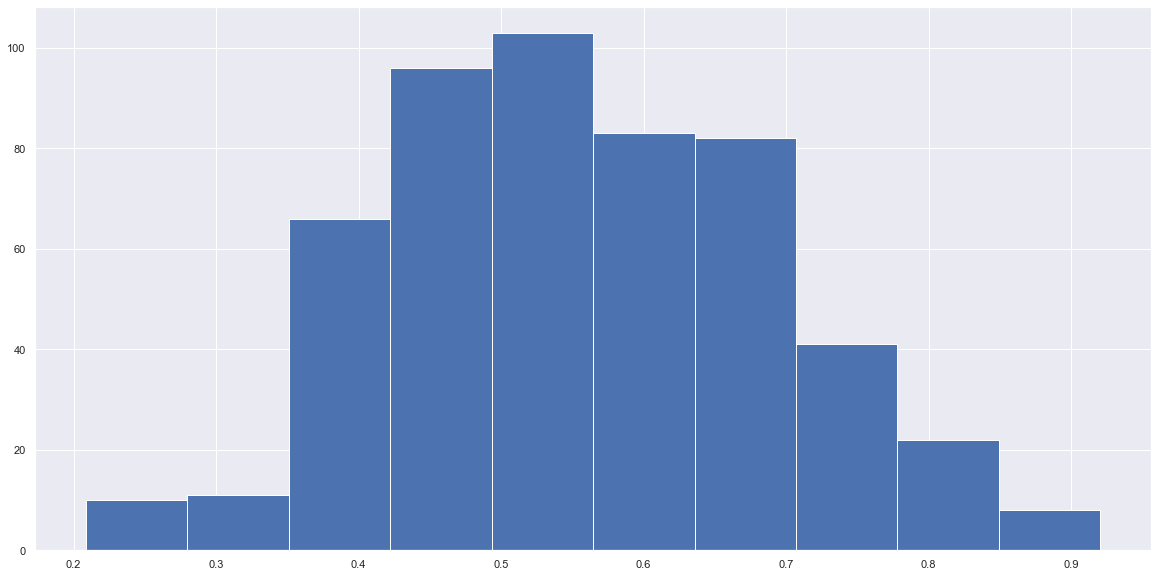

In [103]:
plot_GM_distribution(df2.sample(2))

In [93]:
tree_clf.predict(a[['Manufacturing Region', 'Manufacturing Location Code',
           'Intercompany','Customer industry', 'Customer Region','Top Customer Group',
           'Product family', 'Product group','Make vs Buy','Invoiced qty (shipped)', 'Ordered qty','# of unique products on a quote','Customer First Invoice Date Months',
           'Price last modified date in the ERP Months', 'Invoice Date Months',
           'Order Date Months', 'Born on date Months',
           'Invoice Date Months u godini', 'Ordered Date Months u godini',
           'Log Invoiced qty (shipped)', 'Log Ordered qty', 'Log Cost of part',"Log Labor cost of part","Log Overhead cost of part",
           "Log Material cost of part"]])

array([74.])

# Opcionalno - vizualna reprezentacija stabla odlučivanja

In [106]:
# ovdje korisnik upisuje gdje mu se nalazi direktorij u u kojemu stoji notebook

path="C:\\Users\\Ivan Emanuel Pavlov\\OneDrive - Prirodoslovno-matematički fakultet\\Github\\LUMEN2021\\LUMEN2021\\"

#path= r"C:\Users\Ivan Emanuel Pavlov\OneDrive - Prirodoslovno-matematički fakultet\Github\LUMEN2021\LUMEN2021\"

In [107]:
from sklearn.tree import export_graphviz 


In [108]:
f = open(path+"stablo_odlucivanja_rezultat4.dot", 'w')


In [109]:
#f = open(path+"stablo_odlucivanja_rezultat3.dot", 'w')

from sklearn.tree import export_graphviz 
 
export_graphviz( 
        tree_clf, 
        out_file=f, 
        feature_names=['Manufacturing Region', 'Manufacturing Location Code',
       'Intercompany','Customer industry', 'Customer Region','Top Customer Group',
       'Product family', 'Product group','Make vs Buy','Invoiced qty (shipped)', 'Ordered qty','# of unique products on a quote','Customer First Invoice Date Months',
       'Price last modified date in the ERP Months', 'Invoice Date Months',
       'Order Date Months', 'Born on date Months',
       'Invoice Date Months u godini', 'Ordered Date Months u godini',
       'Log Invoiced qty (shipped)', 'Log Ordered qty', 'Log Cost of part',
       'Log Material of cost of part', 'Log Labor cost of part',
       'Log Overhead cost of part'],
        class_names= pd.Series(sorted(df_model.clusters.unique())).astype(str),
        rounded=True, 
        filled=True, 
        max_depth=3,
    )

